In [1]:
from dataclasses import dataclass
from typing import Tuple, Dict, List, Optional, Iterable, Mapping
from rl.markov_decision_process import FiniteMarkovDecisionProcess
from rl.markov_decision_process import FinitePolicy, StateActionMapping
from rl.markov_process import FiniteMarkovProcess, FiniteMarkovRewardProcess, Transition
from rl.distribution import Categorical, Constant, Choose, FiniteDistribution
from rl.dynamic_programming import *
import pprint as pp
import numpy as np
import itertools

# Problem 3

## 3A

State Space: Each lilypad is a state $s  -> [0:n]$
$\newline$
Action Space: The two types of croaks $[A,B]$ modelled as $[0,1]$

Transition Probability: 
$$ T(s'|s_i,A) = \frac{i}{n}(s_{i - 1}) + \frac{n-i}{n}(s_{i + 1})$$
$$ T(s'|s_i,B) = Uniform[0, 1, 2, ... , n-1, n]$$

## 3B

In [18]:
@dataclass(frozen=True)
class Lilypad:
    state: int
    
    # Was having weird equality problems when indexing into a dict with the state as a key 
    # so I added this in.  It overloads the default == behavior
    def __eq__(self, other):
        if self.state == other.state:
            return True
        else:
            return False

# Maps {States -> Actions}
TransitionMapping = StateActionMapping[Lilypad, int]


# Models the Lilypads game as an MDP
@dataclass
class LilypadMDP(FiniteMarkovDecisionProcess[Lilypad, int]):    
    win: int = 10
    lose: int = 0
    actions: tuple = (0, 1) # Can't make this a list
    #ingredients: List = field(default_factory=lambda: ['dow', 'tomatoes'])
    
    def __post_init__(self):
        self.loopactions = list(self.actions)
        self.statespace = [state for state in range(self.lose, self.win + 1)]
        self.state_actions = self.make_state_action_space()
        self.n = self.win
        super().__init__(self.get_action_transition_reward_map())
    
    # To make the value function equal to the probability of success,
    # make the reward 1 at the win state and 0 everywhere else
    def make_state_action_space(self):
        arr = []
        for state in self.statespace:
            if state == self.lose:
                arr.append((Lilypad(state), 0))
            elif state == self.win:
                arr.append((Lilypad(state), 1))       
            else:
                arr.append((Lilypad(state), 0))
        return arr
    
    def get_action_transition_reward_map(self) -> TransitionMapping:
        # {State -> {Action -> Distribution(Next State, Reward)}}
        d: Dict[Lilypad, Dict[int, Optional[Tuple[Lilypad, float]]]] = {}
        
        # Loops over each state
        for state in self.statespace:
            # {Action -> Distribution(Next State, Reward)}
            d1: Dict[int, Optional[Tuple[Lilypad, float]]] = {}
            
            # Terminal state
            if state == self.lose:
                d1 = None
                
            # Terminal state
            elif state == self.win:
                d1 = None
    
            # Non terminal states
            else:
                # Loops over actions and possbile next states
                for action in self.loopactions:
        
                    # Action A
                    if action == 0:
                        d1[action] = Categorical({self.state_actions[state - 1] : state/self.n, 
                                            self.state_actions[state + 1] : (self.n - state)/self.n})
                    # Action B
                    elif action == 1:
                        d1[action] = Choose(self.state_actions)
                    
                    else: 
                        raise "Bruh what is going on here"
        
            d[Lilypad(state)] = d1

        return d
    
    
# A basic policy where all actions occur with equal probability
# The same actions can be taken everywhere except terminal states
# Policy Maps   Dict[State -> Distribution(Actions)]
def make_basic_policy(statespace, actionslist) -> Mapping[Lilypad, Optional[FiniteDistribution[int]]]:
    d = {}  # Set empty dict
    equal_prob = 1/len(actionslist)   # Normalize Probability
    
    # Loops over each state
    for state in statespace:
        inner_dict = {}           # Creates empty inner dict
        
        # Loops over each action
        for action in actionslist:
            inner_dict[action] = equal_prob
        
        # Sets terminal states to None
        if (state == lose) or (state == win):
            d[Lilypad(state)] = None
        # Sets state to map to created distribution of actions
        else: 
            d[Lilypad(state)] = Categorical(inner_dict)
            
    return d


# Checks each combination of states and actions and returns the optimal policy with the 
# largest value function
def get_optimal_policy(lily: LilypadMDP, gamma: int):
    # Gets common variables from MDP
    lose = lily.lose
    win = lily.win
    actionlist = lily.loopactions
    
    maxvec = np.zeros((1,win-1))        # Sets value function vector to zeros
    best_policy = None                  # Inits the best policy as None
    
    # Gets a list of non-terminal states and their number
    non_terminal_states_list = [state for state in range(lose+1, win)]
    num_nts = len(non_terminal_states_list) # Number of non-terminal states
    
    # Gets an interator for each combination of actions for each non-terminal state
    # Ex 2 non-terminal states, 3 actions -> (0,0),(0,1),(0,2),(1,0),(1,1),(1,2)
    combos = itertools.product(actionlist, repeat=num_nts)
    #  print(list(iter(combos)))

    # Loops over each combination of actions
    for c in combos:
        # Initializes an empty dict of the policy map
        policy_map = {}
        
        # Loops over the number of non-terminal states
        for i in range(num_nts):
            state = non_terminal_states_list[i]  # Get the state value
            
            # Adds each state and action to the policy
            policy_map[Lilypad(state)] = Constant(c[i])
        
        # Add the terminal states
        policy_map[Lilypad(win)] = None
        policy_map[Lilypad(lose)] = None
        
        # Make the finite polciy from the policy map
        policy: FinitePolicy[Lilypad, Optional[FiniteDistribution[int]]] = FinitePolicy(policy_map)

        # Make the Markov Reward Process
        mrp: FiniteMarkovRewardProcess[Lilypad] = lily.apply_finite_policy(policy)
        
        # Get the value function vector of the policy
        v_func_vec = mrp.get_value_function_vec(gamma)
         
        # If the new vector has a better value function sum, then update the max and the policy
        if np.sum(v_func_vec) > np.sum(maxvec):
            maxvec = v_func_vec
            best_policy = policy
                  
    return best_policy     
        

In [19]:
# Plotting Imports
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker       # Used for making the x axis whole numbers
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8] # Chnages default plot size
plt.rcParams.update({'font.size': 22})   # Changes default font size

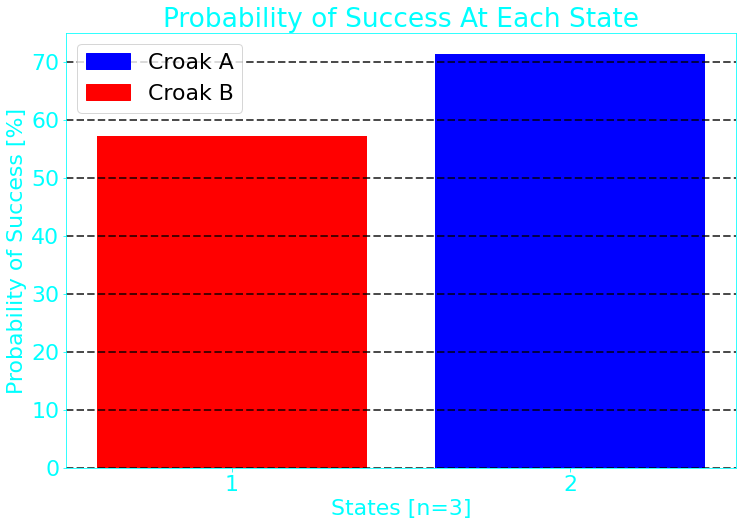

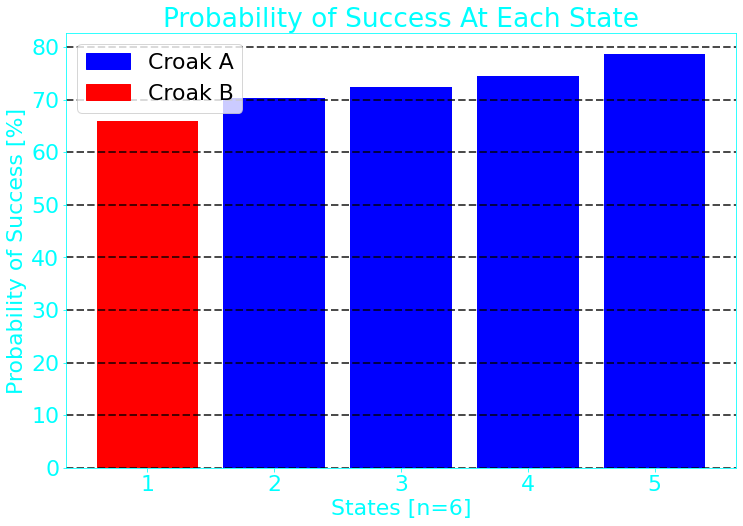

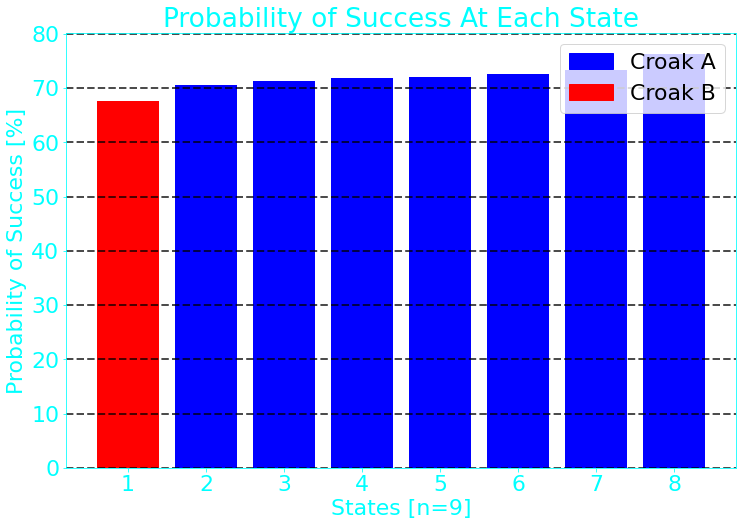

In [20]:
n_list = [3, 6, 9]

for n in n_list:

    # Gamma is 1 since we only care about probability of success
    # So, we only care about long term rewards, meaning gamma = 1.
    # This also means that the reward model was hard coded 
    # to give 1 at win, -1 at lose, and 0 everywhere else
    gamma: float = 1
    win: int = n
    lose: int = 0
    actions: tuple = (0, 1)

    # Used for Basic Function Policy (Not actually used or needed)
    statespace: List[int] = [state for state in range(lose, win+1)]
    actionslist: list = list(actions)

    # Model MDP
    lily = LilypadMDP(win=win, lose=lose, actions=actions)

    # Get Best Policy
    best_policy = get_optimal_policy(lily, gamma)

    # Get Markov Reward Process
    mrp = lily.apply_finite_policy(best_policy)

    # Get Value Function Vector
    v_func_vec = mrp.get_value_function_vec(gamma)



    # Plotting
    #-------------------------------------------------------------------------------------------
    # Gets states, probabilites and actions from policy
    # This works since there is one for each so everything lines up one to one
    states = []
    probs = v_func_vec
    actions = []

    for s, d in best_policy.policy_map.items():
        if d is not None:
            for a, p in d:
                states.append(s.state)
                actions.append(a)        

    # Gives different colors to differnt actions
    colors = []
    for a in actions:
        if a == 1:
            colors.append("red")
        elif a == 0:
            colors.append("blue")
        else:
            colors.append("cyan")

    probs = 100*probs # Converts probabilitites to percent

    # I changed the label and tick colors since I have a dark theme for Jupyter
    custom_color = 'cyan'

    # Plot stuff...
    fig, ax = plt.subplots()
    ax.bar(states, probs, color=colors)
    ax.grid(color="black", linestyle='--', linewidth=2, axis='y', alpha=0.7)

    # Legend
    colormap = {"Croak A":'blue', "Croak B":'red'}         
    labels = list(colormap.keys())
    handles = [plt.Rectangle((0,0),1,1, color=colormap[label]) for label in labels]
    ax.legend(handles, labels)

    # Axes Label stuffs
    ax.set_xlabel('States [n='+str(win)+']').set_color(custom_color)
    ax.set_ylabel('Probability of Success [%]').set_color(custom_color)
    ax.set_title(r'Probability of Success At Each State').set_color(custom_color)
    # Used for making the x axis whole numbers
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True)) 

    # Additional Color Info
    ax.spines['bottom'].set_color(custom_color)
    ax.spines['top'].set_color(custom_color)
    ax.spines['left'].set_color(custom_color)
    ax.spines['right'].set_color(custom_color)
    ax.tick_params(axis='x', colors=custom_color)
    ax.tick_params(axis='y', colors=custom_color)

    # Show Off Baby
    plt.show()

## 3C

### The observed pattern is that you always choose croak B at state 1.  Croak A in state 1 has a higher chance of making you lose, since you can only go forward or backward one state.  Croak B in lets you jump to any state with equal chance so there's more of a chance to jump forward as opposed to jumping to 0 and losing.

# Problem 4

$$Q(s,a) = E[R(s,a) + \gamma V^*(s)] $$
Since $\gamma = 0$:
$$Q(s,a) = E[R(s,a)]$$
$s' \sim ~N(s,\sigma^2)$ and the transition cost of $e^{as'}$ yields
$$Q(s,a) = E[e^{as'}]$$
Since $E[e^xt] = e^{\mu + \frac{\sigma^2 t^2}{2}}$ for $x \sim ~N(\mu,\sigma^2)$
$$f_{s'\sim ~N(s,\sigma^2)} = Q(s,a) = e^{as + \frac{a^2 \sigma^2}{2}}$$
$$f'_{s'\sim ~N(s,\sigma^2)} = E[s'*e^{as'}] = (s + a\sigma^2) * e^{as + \frac{a^2 \sigma^2}{2}}$$
$$f''_{s'\sim ~N(s,\sigma^2)} = E[s'^2*e^{as'}] = ((s + a\sigma^2)^2 + \sigma^2) * e^{as + \frac{a^2 \sigma^2}{2}}$$
To get $V^*$, we need to maximize Q so $V^* = argmax_{a} (Q(s,a))$
$$f'_{s'\sim ~N(s,\sigma^2)} = (s + a^*\sigma^2) * e^{a^*s + \frac{a^{*2} \sigma^2}{2}} = 0$$
$$a^* = \frac{-s}{\sigma^2}$$
$a^*$ is only a maximum when $f''_{s'\sim ~N(s,\sigma^2)} < 0$ which it can't since both parts of f'' will always be positive...
<br>
^^ Not fully sure about this conclusion